# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 양의 데이터셋을 이용해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 양**
- Data 양이 많지 않아 딥러닝 모델의 학습에 어려움이 있을 때 사용 가능한 방법
    - **Image augmentation 활용**
        - Image에 다양한 효과를 주어 데이터양을 늘린다.
            - Train dataset은 전체 대상 이미지들을 샘플링한 것이기 때문에 모든 형태를 다 가지고 있지 않다. Data augmentation은 train set의 이미지에 다양한 효과를 주어 실제 데이터셋과의 간격을 줄인다.
            - 영상데이터의 경우 각 영상 데이터의 색변경, 이미지잘라내기, 회전시키기, 명암변경 등을 적용하여 이미지들을 추가로 만들어 data의 수를 늘린다.
        - **모델의 Overfitting을 개선시킨다.**
        - pytorch image augmentation을 위한 클래스들
            - https://pytorch.org/vision/stable/transforms.html
    - **Pre-trained network**의 활용한 **Transfer learning (전이학습)**
        - 매우 큰 데이터셋으로 미리 Training한 모델을 이용해 모델을 정의한다.
        - 성능이 좋은모델을 다량의 데이터로 학습시킨 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

# Image Augmentation 예제

In [1]:
import torch
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt

In [2]:
# 이미지 출력 함수
def image_show(img_path, transforms):
    """
    이미지 경로와 transforms를 받아서 적용한뒤 원본이미지와 처리된 이미지를 출력한다.
    transforms는 8번 적용시켜 출력한다.
    [parameter]
        img_path: str - transforms를 적용할 이미지 경로
        transforms: Transforms 객체. 단 ToTensor()가 첫번째 transforms로 정의되 있어야 한다.
    """
    # img_path의 이미지를 읽어서 RGB로 변환
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.rcParams['font.family'] = 'AppleGothic'

    plt.figure(figsize=(15, 12))
    plt.subplot(3, 3, 1)
    plt.imshow(img)
    plt.title('원본')

    for i in range(2, 10):  # plot의 index (2번째 ~ 9번째 axis에 이미지 출력)
        result_img = transforms(img)  # 원본이미지를 transform 함수에 넣어서 변경된 결과를 받음
        plt.subplot(3, 3, i)    
        plt.imshow(result_img.permute(1, 2, 0))  # 변환 imgae shape: (ch, h, w) -> matplotlib shape: (h, w, ch)

    plt.tight_layout()
    plt.show()

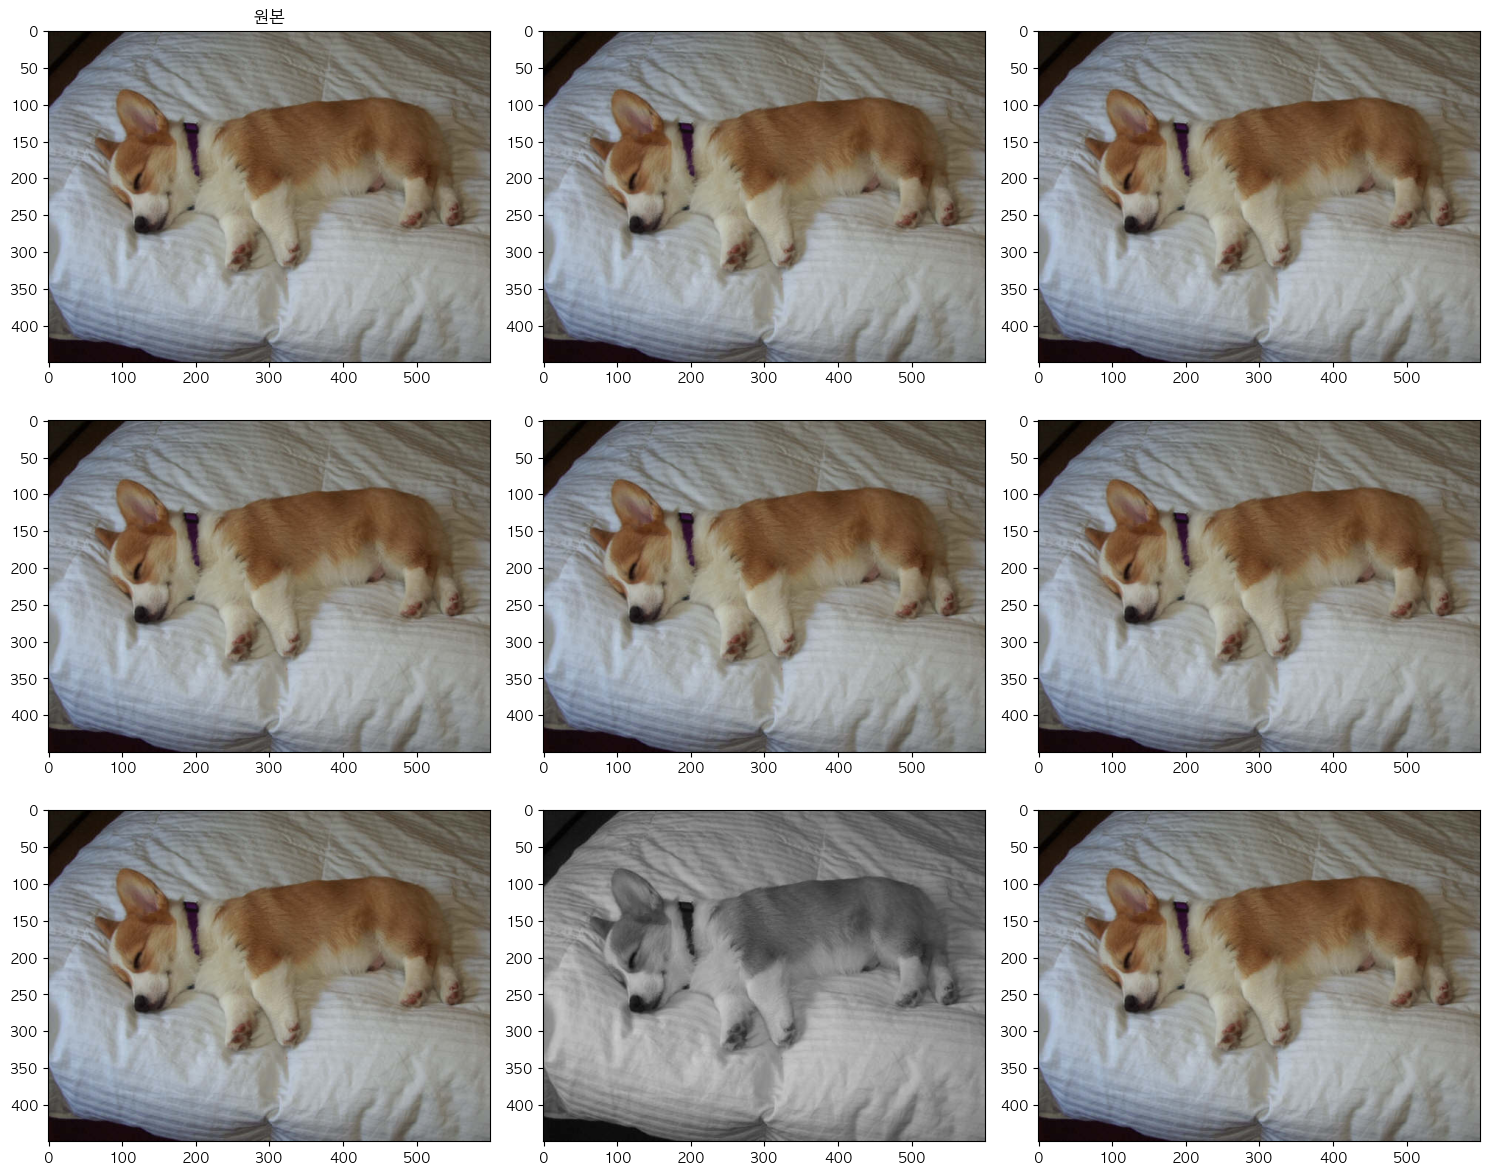

In [8]:
# transforms.Compose([변환함수1, 변환함수2, ... ])  # 변환함수들에 순서대로 이미지를 넣어서 변환 => 변환 파이프라인을 구성
transform = transforms.Compose([
    # - ndarray, PIL.Image 타입 -> torch.Tensor
    # - (height, width, channel) -> (channel, height, width)
    # - pixcel 값들을 0~1 사이로 scaling 처리 (min max scaling)
    transforms.ToTensor()
    # 대부분의 변환함수 -> 랜덤성을 추가 (항상 일정하게 바뀌지 않도록 처리)
    ###########################
    # 좌우/상하 반전. 
    ###########################
#    , transforms.RandomHorizontalFlip(p=0.5)  # p 반전 확률. 좌우 대칭반전
#    , transforms.RandomVerticalFlip(p=0.5)  # 상하 대칭반전
    
    ###########################
    # 회전
    # 회전각도: 정수 - 회전범위: -정수 ~ +정수 (-180 ~ +180)
    ###########################
#    , transforms.RandomRotation(degrees=180)
    
    ###########################
    # affine 이동 변환들
    #  회전, 이동, 전단 변환 처리
    ###########################
#    , transforms.RandomAffine(degrees=(0,0),  # 회전 (최소:-20, 최대:20) - 필수
#                              translate=(0.1,0.3),  # 좌우/상하 이동 (실수: 비율)
#                              shear=(0.8, 1.2),  # 전단변환
#                              scale=(0.5,1.2),  # 이동 후 resize
#                             )
    
    ###########################
    # 가우시안 블러
    ###########################
# ㅊ     , transforms.GaussianBlur(kernel_size=(17,17), sigma=(1, 5))
    # kernel_size/sigma(표준편차)가 클수록 blur 효과가 강해짐 -> 흐려짐 + 잡읍 더 많이 제거
    # sigma - 실수값 하나: 고정, tuple() 범위사이에 랜덤하게 결정 (1, 5) 1 ~ 5
    
    ########################### 
    # 선명도 (Sharpen)
    # sharpness_factor: 1 - 원본과 동일, 1미만 - blur, 1초과 - 샤픈
    # p: 적용될 가능성 (확률)
    ###########################
#    , transforms.RandomAdjustSharpness(sharpness_factor=5, p=0.5) 
    ###########################
    # 색관련 변환
    #  밝기, 대비, 채도, 색 변환 처리
    # 값: 실수 - 0.x [1-0.x ~ 1+0.x]
    #    튜플 - 변화 비율 [min ~ max]
    #    1: 원본
    #    지정된 범위내에서 랜덤하게 선택
    ###########################
#     , transforms.ColorJitter(brightness=(0.5, 1.2),  # 밝기 조정
#                            contrast=(0.8, 1.2),      # 대비 조정
#                            saturation=(0.5, 1.5),    # 채도 조정
#                            hue=(-0.2, 0.2))          # 색 조정 (-0.5이상 ~ 0.5이하)
    
    #########################
    # Grayscale로 변환 -> (3-채널, h, w)
    #########################
#    , transforms.RandomGrayscale(p=0.25)
    
    ############################
    # 반전 - 확률 지정할 수 있다.
    # 픽셀값을 반전 0 <-> 255, 1 <-> 254
    ############################
#     , transforms.RandomInvert(p=0.7)
    
    
    ###########################
    # Center 영역 Crop
    # 정수 (150): h: 150, w: 150
    # 튜플((200, 100)): h: 200, w: 100
    ###########################
#     , transforms.CenterCrop(150)
    
    ############################
    # RandomCrop - Crop 영역을 random하게 선택한다.
    ############################
#     , transforms.RandomCrop(150)

    ###########################
    # RandomResizedCrop - Random한 영역을 Crop후 지정한 종횡비 resize 한다.
    ###########################
#     , transforms.RandomResizedCrop(180, 
#                                    scale=(0.3, 0.7),  # return size 크기율 미율
#                                    ratio=(0.5, 1.5)   # return시 종황비(가료비율), 세로비율
#                                   )
    ##############################
    # 이미지를 부분적으로 삭제한다. (픽셀값을 0으로 변경)
    # p=확률, scale=() 삭제 크기범위, ratio=() 삭제 종횡비 범위 => 지정된 튜플 비율에서 random 하게 선택되 변경됨
    # occlusion(폐색-가려지는 문제)문제에서의 한계를 해결. https://deepapple.tistory.com/8
    ###############################
#     , transforms.RandomErasing()

])

img_path = 'test_img/image.jpg'
image_show(img_path, transform)



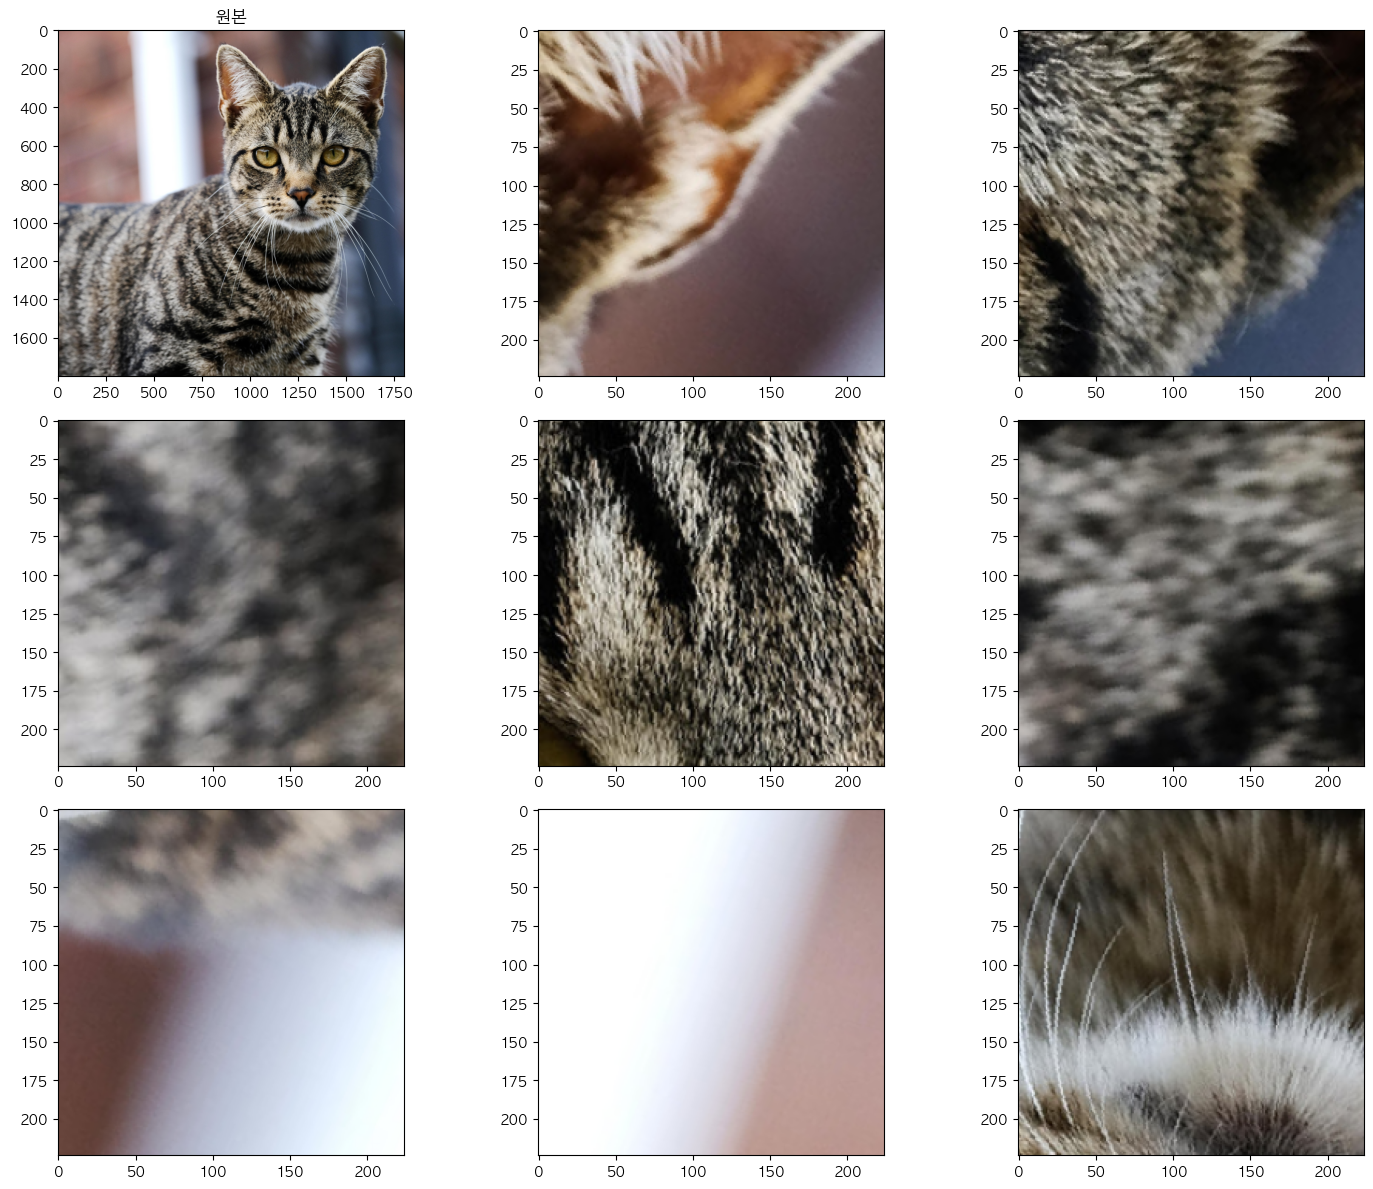

In [9]:

#####################################
# RandomApply() - 여러개 중 Random하게 여러개를 선택해서 적용한다. 선택 확률을 선택할 수 있다.
# RandomChoice() - 여러개 중 하나를 적용한다.
#####################################
transform2 = transforms.Compose([
    transforms.ToTensor()  # 1
    , transforms.RandomApply([
        transforms.RandomHorizontalFlip(),  # 2
        transforms.RandomVerticalFlip(),    # 3
        transforms.RandomRotation(45),      # 4
        transforms.RandomCrop((200,200)),   # 5
    ], p = 0.9)
    , transforms.Resize((224, 224), antialias=True)  # 6
])  # 6개 중 2~6개 실행

# transform2 = transforms.Compose([
#     transforms.ToTensor()  # 1
#     , transforms.RandomChoice([
#         transforms.RandomRotation(45),      # 2
#         transforms.RandomHorizontalFlip(),  # 3
#         transforms.RandomVerticalFlip(),    # 4
#     ])
#     , transforms.Resize((224, 224), antialias=True) # 5
# ])  # 5개 중 3개

image_show('test_img/cat.jpg', transform2)